# Interview task for Nokia - Bartosz Lewandowski
----------------------------------
## I made it in jupyter notebook to show my thinking process 
## First I loaded necessary libraries 

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling 
import csv
import string
import seaborn as sns

from copy import deepcopy

from datetime import datetime

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from matplotlib import pyplot as plt

from mlxtend.frequent_patterns import apriori, association_rules

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

from wordcloud import WordCloud

# Reading the data

## I opened file and "read" it as list without empty lists

In [2]:
lines = []
with open('Cell_Phones_&_Accessories.txt', newline = '') as sales:
    lines = [sale for sale in csv.reader(sales, delimiter='\n') if sale!=[]]

## I have created new list where I splited everything to get clear information without column name

In [3]:
tmp = []
for i in lines:
    for j in i:
        tmp.append(j.split(': '))
        

## I assigned it to lists

In [4]:
length_tmp = len(tmp)
productid =[tmp[i][1] for i in range(0,int(length_tmp),10)]
title =[tmp[i+1][1] for i in range(0,int(length_tmp),10)]
price=[tmp[i+2][1] for i in range(0,int(length_tmp),10)]
userID=[tmp[i+3][1] for i in range(0,int(length_tmp),10)]
profileName =[tmp[i+4][1] for i in range(0,int(length_tmp),10)]
helpfulness = [tmp[i+5][1] for i in range(0,int(length_tmp),10)]
score = [tmp[i+6][1] for i in range(0,int(length_tmp),10)]
time = [tmp[i+7][1] for i in range(0,int(length_tmp),10)]
summary = [tmp[i+8][1] for i in range(0,int(length_tmp),10)]
text = [tmp[i+9][1] for i in range(0,int(length_tmp),10)]

In [5]:
del(tmp,length_tmp)

## Now I have clear data frame on which I can work more efficient than on clear text. 

In [6]:
df = pd.DataFrame({
    'ProductID':productid,
    'Product_Name':title,
    'Price':price,
    'userID':userID,
    'User_Name':profileName,
    'helpfulness':helpfulness,
    'rate':score,
    'time':time,
    'summary':summary,
    'text':text
})

In [7]:
df.head(10)

,ProductID,Product_Name,Price,userID,User_Name,helpfulness,rate,time,summary,text
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,1233360000,Don't buy!,"First of all, the company took my money and se..."
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,1191456000,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,1186704000,good,works real good....a little hard to set up...w...
3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A29Q0CLOF0U8BN,E. Owens,4/5,4.0,1146182400,No instructions included...,The price was right for this cable ($11.95+$4....
4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,1173657600,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...
5,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A2DP6EPPQAIL3C,David M. Cantrell,0/0,4.0,1171584000,works as expected,There's not much to say about a data cable -- ...
6,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A254KU5H615J3N,J. S. Gaviota,0/0,5.0,1142467200,Excellent product!,"I have a Sony Ericsson K700i, which doesn't se..."
7,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,ACVTUAQ4RUGK,"Parathalyn ""Parathalyn""",0/0,1.0,1133654400,Beware 3rd Party Cables & Sony Ericsson Tech S...,"Well, it technically does what it is supposed ..."
8,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A34D9XVHS261KT,D. Cram,1/2,3.0,1135814400,"Undecided on product, but Electro Island is A+...",I currently have this item for my S/E z500a ph...
9,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A3Q3B32YUDC3IK,"Jonathan C. Phillips ""Chris""",6/10,4.0,1126915200,Good cable to have,This is a good cable to have. You don't need t...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78930 entries, 0 to 78929
Data columns (total 10 columns):
ProductID       78930 non-null object
Product_Name    78930 non-null object
Price           78930 non-null object
userID          78930 non-null object
User_Name       78930 non-null object
helpfulness     78930 non-null object
rate            78930 non-null object
time            78930 non-null object
summary         78930 non-null object
text            78930 non-null object
dtypes: object(10)
memory usage: 6.0+ MB


# Cleaning data

## I've assigned 0 to unknow to change type of columns to float, and then 0 as N/A


In [9]:
df = df.replace('unknown',0)

In [10]:
df = df.astype({'Price':'float64',
          'rate': 'float64',
          })

In [11]:
df = df.replace(0.0,np.NaN)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78930 entries, 0 to 78929
Data columns (total 10 columns):
ProductID       78930 non-null object
Product_Name    78930 non-null object
Price           35643 non-null float64
userID          76654 non-null object
User_Name       76654 non-null object
helpfulness     78930 non-null object
rate            78930 non-null float64
time            78930 non-null object
summary         78930 non-null object
text            78930 non-null object
dtypes: float64(2), object(8)
memory usage: 6.0+ MB


## I've made pandas profile report to see a quik overview of data

In [13]:
#df.profile_report()

## I created new column to split this reviews to positive, neutral and negative. I assumed that rate equal to 4.0 and higher is good rate, between 3.0 and 4.0 is possibly neutral, and less than 3 I consider as negative. Usually when I'm shopping and I notice that product has a rate lower than 3.0 I avoid buying this and that was the factor for that decision. 

In [14]:
df['type_of_review'] = df['rate'].apply(lambda rate: "Positive" if rate>=4.0 else ("Neutral" if rate<4.0 and rate>=3.0 else "Negative"))
reviews = df[['text','type_of_review']]

# Basic information about the data

## Barplot to show distribution types of review. 

Text(0.5, 0, 'Type of review')

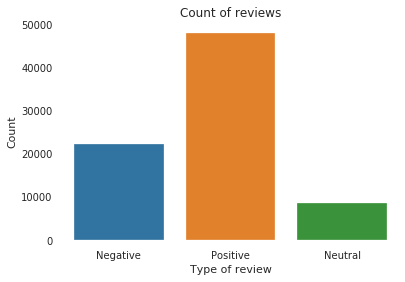

In [15]:
ax = sns.countplot(
    data = df,
    x = df['type_of_review']
)
ax.set_title('Count of reviews')
ax.set_ylabel('Count')
ax.set_xlabel('Type of review')

## I changed time from unix to "standard" and looked at distribution of reviews through time.

In [16]:
df['time'] = df['time'].apply(lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d'))

In [17]:
df['time'] = pd.to_datetime(df['time'])
df['year'] = [x.year for x in df['time']]

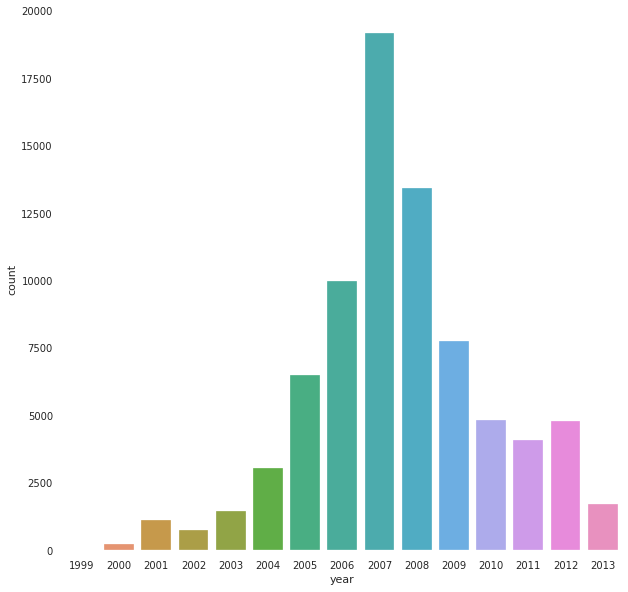

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(
    ax=ax,
    data = df,
    x = df['year']
)

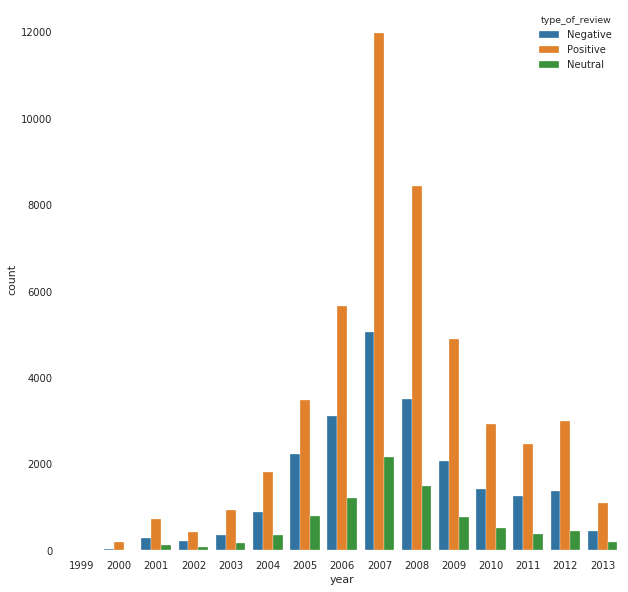

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
sns.countplot(
    ax=ax,
    data = df,
    x = df['year'],
    hue = df['type_of_review']
)

## We can see that the highest peak falls in 2007. Generally the more reviews in total, the more positive, negative and neutral opinions grow. Although there are visible deviations. Maybe it can define better advertisement of the Amazon in 2007.

## I wanted to check if there is some difference between price of product and type of rate, but I noticed that there is the same distribution of price in every type so I decided to remove it in next steps. 

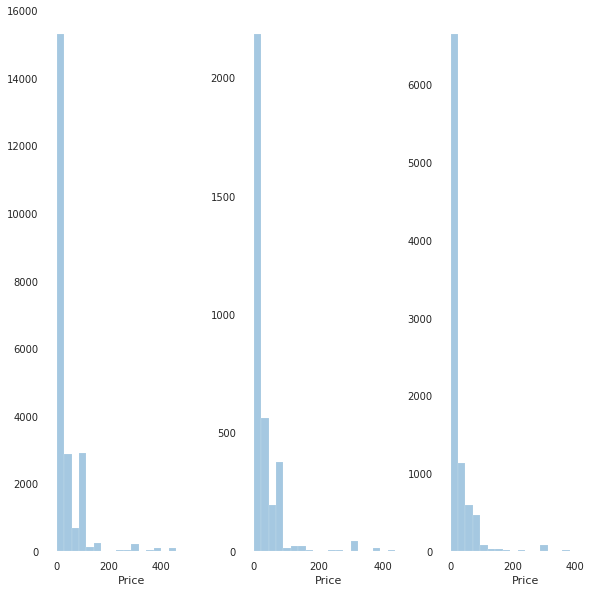

In [20]:
Prices = df.dropna()
f, axes = plt.subplots(1, 3, figsize=(10,10))
sns.distplot(Prices[Prices.type_of_review == 'Positive'].Price,kde=False, bins=20, ax=axes[0])
sns.distplot(Prices[Prices.type_of_review == 'Neutral'].Price,kde=False, bins=20, ax=axes[1])
sns.distplot(Prices[Prices.type_of_review == 'Negative'].Price,kde=False, bins=20, ax=axes[2])

## I combined two columns because, as well as text, summary give us information about coustomer's feelings, and I'll use it later to analyze comments

In [21]:
df['text'] += df['summary']

## I checked if different users can have the same name, and that was the case, so I sorted them by userID in my further work. 

In [22]:
df['User_Name'].nunique()

63369

In [23]:
df['userID'].nunique()

68040

In [24]:
df.groupby('User_Name').userID.count().sort_values(ascending = False)

User_Name
John                     47
Chris                    47
Dave                     45
Mike                     45
Brendon Edwards          44
                         ..
P. Casey                  1
P. Carrne "smileyptc"     1
P. Cardella               1
P. Canady "pcman3550"     1
!!!!!                     1
Name: userID, Length: 63369, dtype: int64

In [25]:
df[df.User_Name == 'Chris'].userID.nunique()

36

# Bestsellers

## I made a bestsellers data frame where we can find products which have count of reviews more than 100 and their rate mean is over 4.0. In this way we can extract these products to main page and for example increase their sales.

In [26]:
df['ProductID'].nunique()

7438

In [27]:
df['Product_Name'].nunique()

7124

In [28]:
products = df.groupby(['ProductID','Product_Name']).helpfulness.count().reset_index().merge(
           df.groupby(['ProductID','Product_Name']).rate.mean().reset_index()
        ) 
products = products.rename(columns = {'helpfulness':'count_rate'})
products = products[(products.count_rate > 100) & (products.rate > 4.0)].reset_index(drop=True)
products.sort_values(by='rate',inplace=True, ascending =False)
bestsellers = products[0:10]

In [29]:
bestsellers

,ProductID,Product_Name,count_rate,rate
17,B000PB8CQI,Multi-Use Vehicle Charger with Dual USB Ports ...,145,4.613793
8,B000ELUXIO,"Palm Horizontal Case for Treo 650, 700",109,4.403670
3,B0007N08NO,Motorola Cigarette Lighter Adapter for Motorol...,344,4.380814
13,B000I8FL0S,BoxWave Galaxy Note 2 / Note DuoSuit - Slim-Fi...,138,4.347826
16,B000LGE1LW,BoxWave Galaxy Note 2 / Note DuoSuit - Slim-Fi...,137,4.343066
12,B000I8C68S,BoxWave Galaxy Note 2 / Note DuoSuit - Slim-Fi...,136,4.338235
15,B000JP8P0I,Nokia OEM Car Charger For Nokia E62,113,4.309735
5,B0009SHMUY,Sony Ericsson USB Cable,124,4.250000
10,B000FL9QGI,BlueAnt Bluetooth Portable Handsfree Supertoot...,184,4.250000
7,B000DZXIRY,Plantronics CS55 Wireless Headset Bundle with ...,105,4.238095


# Apriori algorithm 

## I created new df to avoid modifying the original one.

In [30]:
df2 = df.drop(columns='Price',axis=1)
df2 = df2.drop(df2[df2.Product_Name == ''].index)
df2 = df2.dropna().reset_index()

## Preprocessing for apriori algorithm

In [31]:
df2['Product_Name'] = df2['Product_Name'].str.strip()

In [32]:
tmp = df2.groupby('userID').Product_Name.count().reset_index()

In [33]:
users_to_analyze = list(tmp[tmp.Product_Name >1].userID)

In [34]:
tmp_list = list(df2.userID.isin(users_to_analyze))
tmp_df2 = df2[tmp_list]

In [35]:
tmp_df2.shape

(14248, 12)

In [36]:
users_vs_products = tmp_df2.groupby(['userID', 'Product_Name']).rate.count().unstack().reset_index().fillna(0).set_index('userID')

In [37]:
users_vs_products = users_vs_products.applymap(lambda x: 0 if x<=0 else 1)

## Apriori algorithm 

In [38]:
frq_items = apriori(users_vs_products, min_support = 0.001, use_colnames = True)

In [39]:
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 

## In the second column (consequents) are products to recommend to user when he bought product from the column one (antecedents). The higher the values in columns support and confidence, the greater the likelihood that the user will be interested in the product. 

In [40]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
16,(C2G / Cables to Go 01939 RJ45 Cat5 8 x 8 Modu...,(C2G / Cables to Go 01940 RJ45 Cat5 8 x 8 Modu...,0.001048,0.001048,0.001048,1.000000,954.333333,0.001047,inf
17,(C2G / Cables to Go 01940 RJ45 Cat5 8 x 8 Modu...,(C2G / Cables to Go 01939 RJ45 Cat5 8 x 8 Modu...,0.001048,0.001048,0.001048,1.000000,954.333333,0.001047,inf
4,"(Baggallini Crinkle Phone/PDA Case, Plum)","(Baggallini Crinkle Phone/PDA Case, Dark Olive)",0.001397,0.001397,0.001397,1.000000,715.750000,0.001395,inf
5,"(Baggallini Crinkle Phone/PDA Case, Dark Olive)","(Baggallini Crinkle Phone/PDA Case, Plum)",0.001397,0.001397,0.001397,1.000000,715.750000,0.001395,inf
6,"(Baggallini Crinkle Phone/PDA Case, Steel Blue)","(Baggallini Crinkle Phone/PDA Case, Dark Olive)",0.001397,0.001397,0.001397,1.000000,715.750000,0.001395,inf
...,...,...,...,...,...,...,...,...,...
103,(Plantronics Voyager 510 Bluetooth Headset [Re...,(Plantronics USB Adaptor Explorer 320 Voyager),0.083304,0.001397,0.001048,0.012579,9.003145,0.000931,1.011324
13,(Plantronics Voyager 510 Bluetooth Headset [Re...,(BlueAnt X3 Micro Bluetooth Headset (Black)),0.083304,0.004017,0.001048,0.012579,3.131529,0.000713,1.008671
1,(Plantronics Voyager 510 Bluetooth Headset [Re...,"(Aliph Jawbone Bluetooth Headset (Grey) [Bulk,...",0.083304,0.005239,0.001048,0.012579,2.400839,0.000611,1.007433
19,(Plantronics Voyager 510 Bluetooth Headset [Re...,(Cardo Systems SCALA 500 Bluetooth Headset),0.083304,0.009780,0.001048,0.012579,1.286164,0.000233,1.002834


# Comments analysis

In [41]:
df['bad_rate'] = df['rate'].apply(lambda x: 1 if x < 4.0 else 0)

## I take a fraction of data to make calculation faster. 

In [42]:
reviews_df = df[['text','bad_rate']]
reviews_df = reviews_df.sample(frac = 0.4, replace = False, random_state=133)


## Preprocessing

In [43]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    


def clean_review(text):
    text = text.lower()
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t) > 0]
    pos_tags = pos_tag(text)
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    text = [t for t in text if len(t) > 1]
    text = " ".join(text)
    return(text)

reviews_df["review_clean"] = reviews_df["text"].apply(lambda x: clean_review(x))

In [44]:
sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["text"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

In [45]:
reviews_df["nb_chars"] = reviews_df["text"].apply(lambda x: len(x))
reviews_df["nb_words"] = reviews_df["text"].apply(lambda x: len(x.split(" ")))

In [46]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [47]:
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

## A wordmap to see which words were the most common

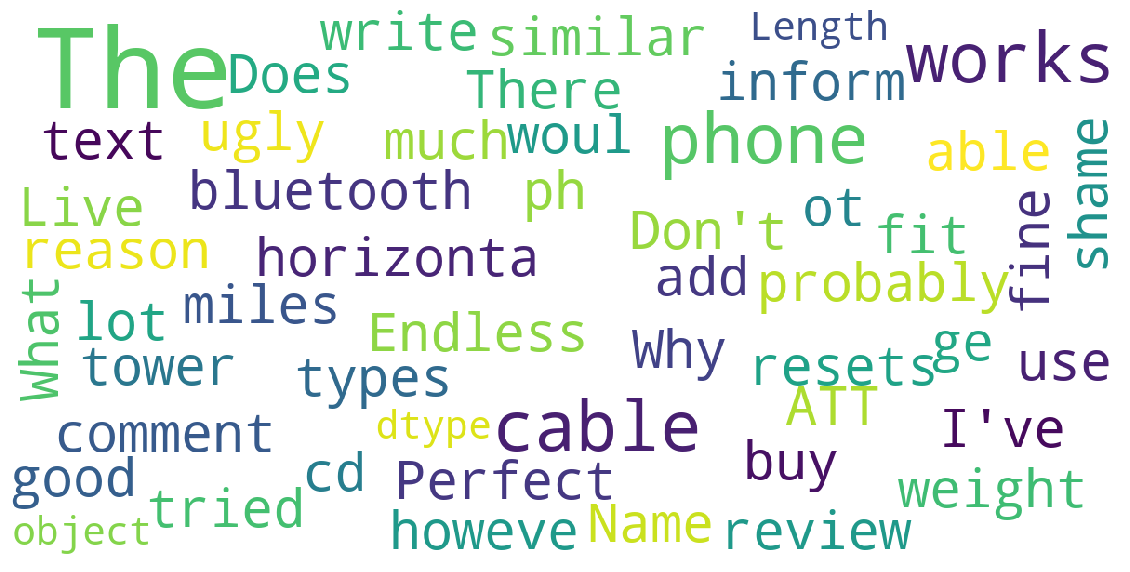

In [48]:
def wordcloud_map(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
wordcloud_map(reviews_df["text"])

## The most positively marked words

In [49]:
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["text", "pos"]].head(10)

,text,pos
75228,Great delivery and great product!Excellent,0.739
44200,Happy w/product! A True Pleasure Doing Busines...,0.732
33531,Great voice clarity. very comfortable around y...,0.713
18707,This is a good product with a great price.Work...,0.685
36703,I love it great product A + + + + + + + + + + ...,0.675
71544,I love it great product A + + + + + + + + + + ...,0.675
49345,I love it great product A + + + + + + + + + + ...,0.675
78348,"ProsLight, comfortable, great for eyeglass wea...",0.673
36455,"ProsLight, comfortable, great for eyeglass wea...",0.673
30299,"Great deal, great product. Everything included...",0.658


## The most negative words

In [50]:
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["text", "neg"]].head(10)

,text,neg
23445,ProsBuilt tough but weak sound,0.630
37617,I was unduly harsh with the 1-starMy Bad,0.561
14707,Bad qualityPoor Quality + No Direct USB Adapter,0.533
73507,I hate this phone.ProsHeavy and hard to use,0.505
43469,"Pro'seither defective or bad design, soon to k...",0.478
11283,*First the bad- 1Needs work,0.467
2169,"The GoodThe Good, The Bad, and The Ugly",0.463
51551,Horrible horrible horrible. Go to the store an...,0.461
10681,I bought but it dont work fine. The software i...,0.458
45745,"The good newsGood, but battery died",0.452


## Random Forest Classifier to recognize type of comments 

In [51]:
label = "bad_rate"
ignore_cols = [label, "text", "review_clean"]
features = [i for i in reviews_df.columns if i not in ignore_cols]



X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

In [52]:
RFcls = RandomForestClassifier(random_state = 133)
RFcls.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=133,
                       verbose=0, warm_start=False)

## Roc curve to see how good our algorithm is. 

In [53]:
def plot_roc_curve(fpr,tpr):
  plt.figure(figsize = (15,10))
  plt.plot(fpr,tpr,color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend(loc="lower right")
  plt.show()    

In [54]:
y_pred_prob = [x[1] for x in RFcls.predict_proba(X_test)]

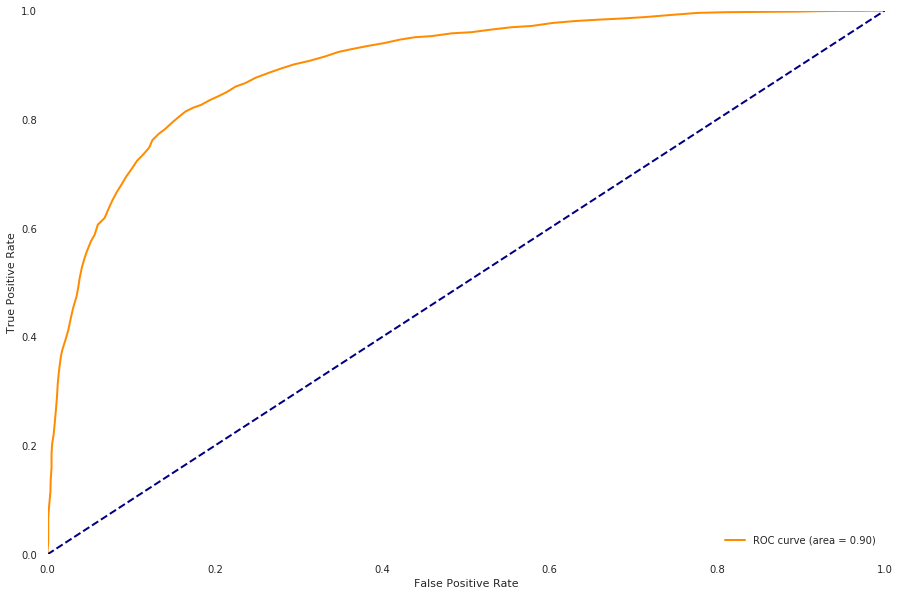

In [55]:
lw=2
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
roc_auc = auc(fpr, tpr)
plot_roc_curve (fpr,tpr)

## Accuracy 

In [56]:
y_pred = RFcls.predict(X_test)
y_test = y_test.reset_index(drop=True)
n=0
for v1, v2 in zip(y_test, y_pred):
    if v1 == v2:
        n+=1
accuracy = n/len(y_pred)
accuracy

0.8242280285035629

## Accuracy at 0.82 as well as convexed roc curve indicates that model is well build and it can be used for that task. 

# Best 3 reviews for each product.

In [57]:
df3 = deepcopy(df2[['Product_Name','userID','helpfulness','rate','text']])

In [58]:
helpful = []
total_vote=[]
for i in df3['helpfulness']:
    a = i.split('/')
    helpful.append(int(a[0]))
    total_vote.append(int(a[1]))
    
df3['helpful'] = helpful
df3['total_vote'] = total_vote

In [59]:
df3['help_percentage'] = [x/y if y!=0 else np.NaN for x,y in zip(helpful,total_vote) ]

In [60]:
min(df3.total_vote)

0

In [61]:
max(df3.total_vote)

1243

In [62]:
df3 = df3.dropna()

## I decided that 20 opinions is enough to include them as reliable

In [63]:
df3 = df3[df3.total_vote >20].reset_index(drop=True)

In [64]:
def best_opinions(product):
    tmp_df3 = df3[df3.Product_Name == str(product)]
    tmp_df3 = tmp_df3.sort_values('help_percentage',ascending = False).head(3)
    return(tmp_df3)
    

In [65]:
best_opinions(df3['Product_Name'][0])

,Product_Name,userID,helpfulness,rate,text,helpful,total_vote,help_percentage
1,Jabra EarGels - Clear,A2GF8B306HPMIR,45/46,4.0,I was in hell with my Jawbone until I got thes...,45,46,0.978261
0,Jabra EarGels - Clear,A24IASWJ7MYWSQ,220/227,4.0,Length:Great Compliment to Jawbone 2,220,227,0.969163
2,Jabra EarGels - Clear,AI7PVP3KWZBUG,28/29,5.0,Works Perfectly with Jawbone II. Jawbone is th...,28,29,0.965517


# Most active users

In [66]:
df.groupby(['userID']).userID.count().sort_values(ascending=False).head(20)


userID
A1RCGK44YXNBBB    44
A5JLAU2ARJ0BO     44
A2C8IPPOF90CJG    38
A33FS5H3CPDR6D    31
A4IX5FZOWQVQN     26
A3ILVGZSKUCC5Z    24
A149RNR5RH19YY    23
AJMBX04BZWPSD     21
A1SFCPHZK18NEH    20
A2KRKPJBMHION0    18
A1N5FSCYN4796F    17
A1F9Z42CFF9IAY    17
A2XQLC4BK7E266    16
A3PM1QNZ1O8EXF    16
A339F4I8GBN3H3    16
A3225WITBT2B09    14
A3SO1NVAN1TI03    13
A3OQPZ3ORSZKQD    13
A10U3Z35FCPXF2    12
A3MQS2KZCUM1IZ    12
Name: userID, dtype: int64

In [67]:
df[df.userID == 'A1RCGK44YXNBBB']

,ProductID,Product_Name,Price,userID,User_Name,helpfulness,rate,time,summary,text,type_of_review,year,bad_rate
3493,B000FOEN9K,Wall AC Adapter Travel Charger [w/ IC Chip] fo...,2.95,A1RCGK44YXNBBB,Brendon Edwards,0/0,5.0,2007-05-07,great product highly recommended!,"Easy to use, if you have a Samsung phone, this...",Positive,2007,0
5212,B00074V0JY,Motorola Lithium-Ion Battery BR50 / SNN5696 / ...,4.51,A1RCGK44YXNBBB,Brendon Edwards,2/3,5.0,2007-04-20,Cheap and with good quality,"I lost the charge for my Motorola RAZR V3, and...",Positive,2007,0
6682,B00006690A,Jabra EarBoom Winder for Phones with Universal...,6.49,A1RCGK44YXNBBB,Brendon Edwards,1/1,5.0,2007-05-03,Great headset!,"As usual, on time delivery and the product wor...",Positive,2007,0
9276,B000EBHW4W,MOTOROLA OEM BR50 BATTERY FOR RAZR V3 V3c V3m ...,4.90,A1RCGK44YXNBBB,Brendon Edwards,3/4,5.0,2007-04-22,genuine Motorals battery,The battery arrived as promised and it has wor...,Positive,2007,0
9289,B000EBHW4W,MOTOROLA OEM BR50 BATTERY FOR RAZR V3 V3c V3m ...,4.90,A1RCGK44YXNBBB,Brendon Edwards,3/4,5.0,2007-04-22,genuine Motorals battery,The battery arrived as promised and it has wor...,Positive,2007,0
9652,B000NHS9YE,Samsung ALIAS U740 SCH-U740 A437 SGH-A437 SYNC...,5.00,A1RCGK44YXNBBB,Brendon Edwards,0/0,5.0,2007-05-15,Works great with a great price,This is a good product with a great price. All...,Positive,2007,0
10682,B000DZUJ9Y,NOKIA DKU-5 USB Data Charging Cable,8.99,A1RCGK44YXNBBB,Brendon Edwards,0/0,5.0,2007-05-09,Works well,I was very pleased with the price and quality ...,Positive,2007,0
15221,B000FOHE6E,,NaN,A1RCGK44YXNBBB,Brendon Edwards,0/0,5.0,2007-05-15,cool case!,the case looks great and fits great and for th...,Positive,2007,0
17176,B000NHXNCC,Original Motorola K1m Li-Ion Standard Battery ...,4.60,A1RCGK44YXNBBB,Brendon Edwards,6/6,5.0,2007-05-09,Good buy!,It is exactly an oem product.The seller eforci...,Positive,2007,0
23511,B000FGZRFC,Motorola RAZR V3 & V3c Pink Silicone Skin Case,NaN,A1RCGK44YXNBBB,Brendon Edwards,0/0,5.0,2007-05-07,Good buy!,The item arrived in perfect condition. The cas...,Positive,2007,0


# Summary 

## I cleaned and preprocess the data for further analysis and tried to take as more as I could information from it. I've used basics algorithms and tried to show results as clear as possible but I think there is more to be done with this data. 
## I've extraced best selling products, most active users, comments the users considered the most useful for each product. Also I've divided comments by their rate and by random forest classification with nltk library. The data has a lot missing rows in Price column so I decided to remove it, also I removed rest of the missing data by rows, not columns. 